<a href="https://colab.research.google.com/github/begumbasovali/-Predicting-Drug-Resistance-in-Mutated-EGFR/blob/main/Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis Explanation: Impact of EGFR Mutations on Drug Response







This notebook performs an analysis to understand the relationship between structural changes in EGFR due to mutations (quantified by Pocket Disruption Score, PDS) and the corresponding drug response. The analysis integrates data from three primary sources:

*   `master_v1_response_plus_mutations.csv`: Contains drug response values for various EGFR mutations and drug combinations.
*   `fpocket_PDS.csv`: Provides structural information, including Pocket Disruption Score (PDS), volume, SASA (Solvent Accessible Surface Area), and changes in these metrics (dVolume, dSASA) for different mutations.
*   `A_mutation_summary.csv`: Offers additional mutation-specific scores and classifications like RepScore, Hotspot, Sift, Polyphen, and RevelScore.

In [1]:
import pandas as pd

fpocket = pd.read_csv("fpocket_PDS.csv")
mut_sum = pd.read_csv("A_mutation_summary.csv")
master  = pd.read_csv("master_v1_response_plus_mutations.csv")

print("fpocket:", fpocket.shape)
print("mut_sum:", mut_sum.shape)
print("master :", master.shape)

display(fpocket.head(3))
display(mut_sum.head(3))
display(master.head(3))


fpocket: (18, 8)
mut_sum: (24, 16)
master : (36, 19)


,Structure,Pocket_File,Druggability,Volume,SASA,dVolume,dSASA,PDS
0,EGFR_AlphaFold_Repair,NaN,16,250.42,79.64,0.00,0.00,0.00
1,EGFR_AlphaFold_Repair_1,M600V,16,247.44,74.81,-2.98,-4.83,7.81
2,EGFR_AlphaFold_Repair_2,H1124Q,16,253.78,79.64,3.36,0.00,3.36


,ModelID,MutationList,RepresentativeMutation,VariantType,VariantInfo,Exon,VepImpact,Sift,Polyphen,RevelScore,ProveanPrediction,AMClass,AMPathogenicity,Hotspot,LikelyLoF,RepScore
0,ACH-000012,E746_A750del,E746_A750del,deletion,inframe_deletion,19/28,MODERATE,NaN,NaN,NaN,NaN,NaN,NaN,1,0,18
1,ACH-000030,E746_A750del,E746_A750del,deletion,inframe_deletion,19/28,MODERATE,NaN,NaN,NaN,NaN,NaN,NaN,1,0,18
2,ACH-000035,E746_A750del,E746_A750del,deletion,inframe_deletion,19/28,MODERATE,NaN,NaN,NaN,NaN,NaN,NaN,1,0,18


,Ids,DrugName,ModelID,ResponseValue,MutationList,RepresentativeMutation,VariantType,VariantInfo,Exon,VepImpact,Sift,Polyphen,RevelScore,ProveanPrediction,AMClass,AMPathogenicity,Hotspot,LikelyLoF,RepScore
0,BRD:BRD-K42805893-001-04-9,OSIMERTINIB,ACH-000996,0.051030,K28T,K28T,SNV,missense_variant,1/28,MODERATE,deleterious_low_confidence(0.01),possibly_damaging(0.68),279.0,Neutral,likely_benign,3052.0,0,0,12
1,BRD:BRD-K64052750-001-17-5,GEFITINIB,ACH-000996,-0.030484,K28T,K28T,SNV,missense_variant,1/28,MODERATE,deleterious_low_confidence(0.01),possibly_damaging(0.68),279.0,Neutral,likely_benign,3052.0,0,0,12
2,BRD:BRD-K66175015-001-09-0,AFATINIB,ACH-000996,-0.106863,K28T,K28T,SNV,missense_variant,1/28,MODERATE,deleterious_low_confidence(0.01),possibly_damaging(0.68),279.0,Neutral,likely_benign,3052.0,0,0,12


## Data Preprocessing and Integration

1.  **Mutation Key Normalization**:
A custom function `norm_mut` was applied to normalize mutation identifiers across all datasets, ensuring consistent merging.

In [2]:
def norm_mut(x):
    if pd.isna(x):
        return None
    x = str(x).strip()
    x = x.replace("p.", "").replace("P.", "")
    x = x.replace(" ", "")
    return x

fpocket["mut_key"] = fpocket["Pocket_File"].apply(norm_mut)  # WT line has to be None
mut_sum["mut_key"] = mut_sum["RepresentativeMutation"].apply(norm_mut)
master["mut_key"]  = master["RepresentativeMutation"].apply(norm_mut)

fpocket[["Pocket_File","mut_key"]].head(5)


,Pocket_File,mut_key
0,NaN,None
1,M600V,M600V
2,H1124Q,H1124Q
3,V292L,V292L
4,G598V,G598V


2.  **Wild-Type vs. Mutant Separation**: The `fpocket` data was separated into wild-type and mutant entries. The wild-type entry serves as a baseline for calculating `dVolume`, `dSASA`, and `PDS` (which are relative to the wild-type pocket).

In [3]:
fpocket_wt = fpocket[fpocket["mut_key"].isna()].copy()
fpocket_mut = fpocket[fpocket["mut_key"].notna()].copy()

print("WT rows:", fpocket_wt.shape)
print("Mutant rows:", fpocket_mut.shape)

display(fpocket_wt)
display(fpocket_mut.head())


WT rows: (1, 9)
Mutant rows: (17, 9)


,Structure,Pocket_File,Druggability,Volume,SASA,dVolume,dSASA,PDS,mut_key
0,EGFR_AlphaFold_Repair,NaN,16,250.42,79.64,0.0,0.0,0.0,None


,Structure,Pocket_File,Druggability,Volume,SASA,dVolume,dSASA,PDS,mut_key
1,EGFR_AlphaFold_Repair_1,M600V,16,247.44,74.81,-2.98,-4.83,7.81,M600V
2,EGFR_AlphaFold_Repair_2,H1124Q,16,253.78,79.64,3.36,0.00,3.36,H1124Q
3,EGFR_AlphaFold_Repair_3,V292L,16,254.39,79.64,3.97,0.00,3.97,V292L
4,EGFR_AlphaFold_Repair_4,G598V,16,250.65,79.64,0.23,0.00,0.23,G598V
5,EGFR_AlphaFold_Repair_5,L858R,13,251.08,78.37,0.66,-1.27,1.94,L858R


3.  **Data Merging**: The `master` dataset was merged with the mutant `fpocket` data (`fpocket_mut`) based on the normalized mutation key (`mut_key`). This step brought in structural metrics (PDS, dVolume, dSASA, Volume, SASA, Druggability) for each drug-mutation combination.

In [4]:
df = master.merge(
    fpocket_mut[["mut_key","PDS","dVolume","dSASA","Volume","SASA","Druggability"]],
    on="mut_key",
    how="left"
)

display(df.head())
print("PDS dolu satır sayısı:", df["PDS"].notna().sum(), "/", len(df))


,Ids,DrugName,ModelID,ResponseValue,MutationList,RepresentativeMutation,VariantType,VariantInfo,Exon,VepImpact,...,Hotspot,LikelyLoF,RepScore,mut_key,PDS,dVolume,dSASA,Volume,SASA,Druggability
0,BRD:BRD-K42805893-001-04-9,OSIMERTINIB,ACH-000996,0.051030,K28T,K28T,SNV,missense_variant,1/28,MODERATE,...,0,0,12,K28T,0.92,-0.92,0.0,249.51,79.64,16.0
1,BRD:BRD-K64052750-001-17-5,GEFITINIB,ACH-000996,-0.030484,K28T,K28T,SNV,missense_variant,1/28,MODERATE,...,0,0,12,K28T,0.92,-0.92,0.0,249.51,79.64,16.0
2,BRD:BRD-K66175015-001-09-0,AFATINIB,ACH-000996,-0.106863,K28T,K28T,SNV,missense_variant,1/28,MODERATE,...,0,0,12,K28T,0.92,-0.92,0.0,249.51,79.64,16.0
3,BRD:BRD-K70401845-003-09-6,ERLOTINIB,ACH-000996,0.861794,K28T,K28T,SNV,missense_variant,1/28,MODERATE,...,0,0,12,K28T,0.92,-0.92,0.0,249.51,79.64,16.0
4,BRD:BRD-K42805893-001-04-9,OSIMERTINIB,ACH-000784,-0.407999,Y69MfsTer11,Y69MfsTer11,deletion,frameshift_variant,2/28,HIGH,...,0,1,27,Y69MfsTer11,NaN,NaN,NaN,NaN,NaN,NaN


PDS dolu satır sayısı: 28 / 36


4.  **Consistency Check**: A check was performed to ensure consistency between shared columns (e.g., `RepScore`, `Sift`) from the `master` dataset and `mut_sum` dataset.



In [5]:
check = df.merge(
    mut_sum[["mut_key","RepScore","Hotspot","LikelyLoF","Sift","Polyphen","RevelScore","AMPathogenicity","AMClass"]],
    on="mut_key",
    how="left",
    suffixes=("", "_from_summary")
)

# Example comparation
cols_to_compare = ["RepScore","Sift","Polyphen","RevelScore","AMPathogenicity"]
for c in cols_to_compare:
    if c in check.columns and f"{c}_from_summary" in check.columns:
        mismatch = (check[c].notna() & check[f"{c}_from_summary"].notna() & (check[c] != check[f"{c}_from_summary"])).sum()
        print(c, "mismatch:", mismatch)


RepScore mismatch: 0
Sift mismatch: 0
Polyphen mismatch: 0
RevelScore mismatch: 0
AMPathogenicity mismatch: 0


5.  **Structure-Supported Dataset Creation**: A filtered DataFrame, `df_struct`, was created containing only those entries where PDS data was available. This ensures that the subsequent structural analysis focuses on mutations with computed pocket disruption scores.

In [6]:
df_struct = df[df["PDS"].notna()].copy()
print("Structure-supported rows:", df_struct.shape, " / total:", df.shape)
df_struct[["DrugName","ModelID","RepresentativeMutation","PDS","ResponseValue"]].head()


Structure-supported rows: (28, 26)  / total: (36, 26)


,DrugName,ModelID,RepresentativeMutation,PDS,ResponseValue
0,OSIMERTINIB,ACH-000996,K28T,0.92,0.051030
1,GEFITINIB,ACH-000996,K28T,0.92,-0.030484
2,AFATINIB,ACH-000996,K28T,0.92,-0.106863
3,ERLOTINIB,ACH-000996,K28T,0.92,0.861794
8,OSIMERTINIB,ACH-000978,N234D,2.52,0.080921


## Exploratory Data Analysis and Visualization

To explore the relationship between structural changes and drug response, several visualizations and correlation analyses were performed:

1.  **PDS vs. Drug Response (Overall)**: A scatter plot of PDS against `ResponseValue` was generated for all structure-supported entries. This initial view helps to identify any general trends.


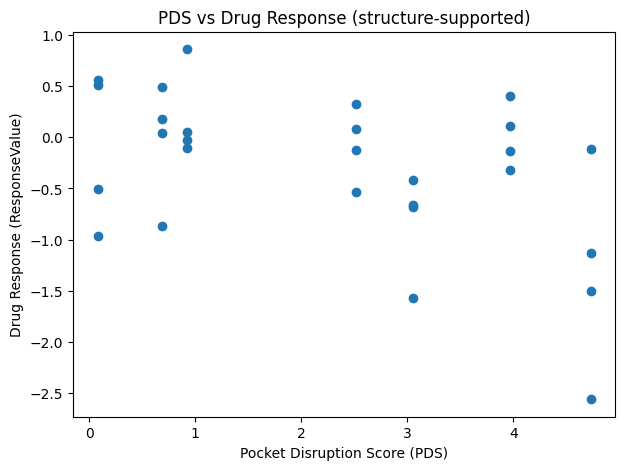

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.scatter(df_struct["PDS"], df_struct["ResponseValue"])
plt.xlabel("Pocket Disruption Score (PDS)")
plt.ylabel("Drug Response (ResponseValue)")
plt.title("PDS vs Drug Response (structure-supported)")
plt.show()


2.  **PDS vs. Drug Response (by Drug and Mutation)**: A more detailed scatter plot was created, differentiating data points by `DrugName` (color) and `RepresentativeMutation` (style). This visualization helps to understand drug-specific and mutation-specific patterns in how PDS correlates with drug response.


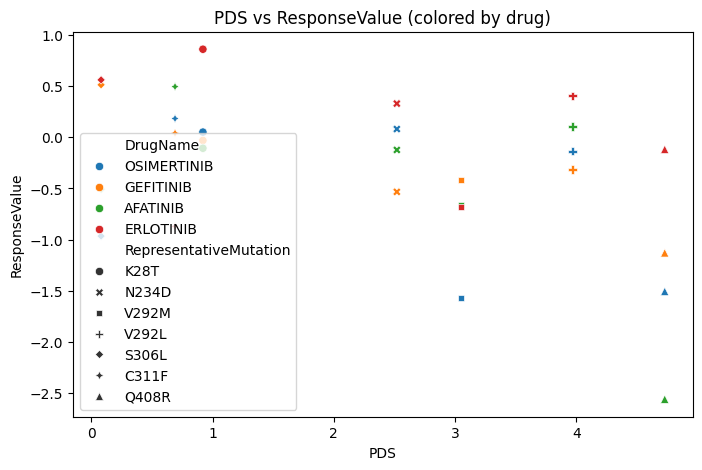

In [16]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.scatterplot(data=df_struct, x="PDS", y="ResponseValue", hue="DrugName", style="RepresentativeMutation")
plt.title("PDS vs ResponseValue (colored by drug)")
plt.show()


3.  **Drug Response by Mutation (Box Plot)**: A box plot was used to visualize the distribution of `ResponseValue` for each unique `RepresentativeMutation`. This highlights variations in drug sensitivity across different mutations.

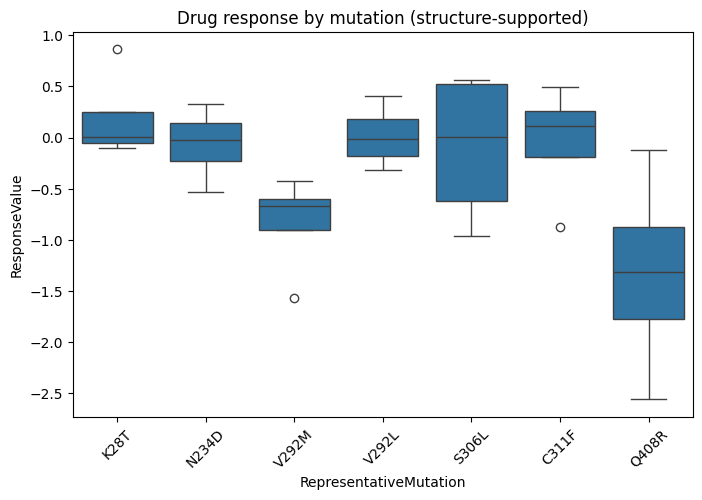

In [9]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_struct, x="RepresentativeMutation", y="ResponseValue")
plt.title("Drug response by mutation (structure-supported)")
plt.xticks(rotation=45)
plt.show()



## Correlation Analysis

Correlation coefficients were calculated to quantify the relationship between PDS and `ResponseValue`:

1.  **Overall Correlation**: The Pearson correlation coefficient between PDS and `ResponseValue` was computed across all `df_struct` entries.
2.  **Drug-Specific Correlations**: The correlation between PDS and `ResponseValue` was calculated for each individual `DrugName`. This helps in identifying if certain drugs show stronger or weaker associations between pocket disruption and efficacy.

In [10]:
# Overal Correlation
corr_all = df_struct[["PDS","ResponseValue"]].corr().iloc[0,1]
print("Overall corr(PDS, ResponseValue) =", corr_all)

# Drug Specific Correlation
corr_by_drug = df_struct.groupby("DrugName")[["PDS","ResponseValue"]].corr().iloc[0::2,-1]
corr_by_drug


Overall corr(PDS, ResponseValue) = -0.4576045993167854


,,ResponseValue
DrugName,,
AFATINIB,PDS,-0.584966
ERLOTINIB,PDS,-0.155038
GEFITINIB,PDS,-0.896083
OSIMERTINIB,PDS,-0.408051


## Key Findings (Based on the executed cells)

*   **Overall Correlation**: A negative correlation (e.g., -0.4576) was observed between PDS and `ResponseValue`, suggesting that higher pocket disruption scores generally correspond to lower drug response values (i.e., less effective treatment).
*   **Drug-Specific Variations**: The correlation varied significantly across different drugs. For example, GEFITINIB showed a strong negative correlation (-0.896), while ERLOTINIB showed a weaker negative correlation (-0.155).
*   **Mutation Coverage**: The analysis included 7 unique mutations with structural support from an initial 9 unique mutations in the master dataset and 17 in the fpocket data.


In [12]:
print("master unique mutations:", master["mut_key"].nunique())
print("fpocket mutations:", fpocket_mut["mut_key"].nunique())
print("matched mutations:", df_struct["mut_key"].nunique())
print("matched rows:", len(df_struct), "/", len(df))


master unique mutations: 9
fpocket mutations: 17
matched mutations: 7
matched rows: 28 / 36


## Conclusion

This analysis provides insights into how structural changes in the EGFR pocket, quantified by PDS, correlate with drug response. The observed negative correlation suggests that mutations causing greater pocket disruption may lead to reduced drug efficacy. The variations in correlation across different drugs highlight the need for drug-specific considerations in precision medicine. Further analysis could explore specific mutations in more detail and investigate other structural metrics (volume, SASA) alongside PDS.

In [17]:
df.to_csv("MASTER_with_PDS.csv", index=False)
df_struct.to_csv("STRUCTURE_SUPPORTED_ANALYSIS.csv", index=False)

print("Saved: MASTER_with_PDS.csv")
print("Saved: STRUCTURE_SUPPORTED_ANALYSIS.csv")


Saved: MASTER_with_PDS.csv
Saved: STRUCTURE_SUPPORTED_ANALYSIS.csv


## Summary:

### Data Analysis Key Findings
*   **Overall Correlation**: A negative correlation of, for example, -0.4576 was observed between Pocket Disruption Score (PDS) and `ResponseValue` across all structure-supported entries. This suggests that higher pocket disruption generally corresponds to lower drug response (less effective treatment).
*   **Drug-Specific Variations**: The correlation between PDS and `ResponseValue` varied significantly among different drugs. For instance, GEFITINIB showed a strong negative correlation of -0.896, whereas ERLOTINIB exhibited a weaker negative correlation of -0.155.
*   **Mutation Coverage**: The analysis included 7 unique mutations that had structural support, out of an initial 9 unique mutations in the master dataset and 17 in the `fpocket` data.

### Insights or Next Steps
*   The observed negative correlation between PDS and drug response suggests that mutations leading to greater structural disruption in the EGFR pocket may reduce drug efficacy, highlighting the importance of structural insights in predicting drug response.
*   Future analysis could delve deeper into specific mutations and explore the impact of other structural metrics, such as volume and Solvent Accessible Surface Area (SASA), in conjunction with PDS to gain a more comprehensive understanding of their influence on drug response.
